# Sprint クラスタリングk-means

In [1]:
import numpy as np
import random
import pandas as pd
from numpy import linalg as LA
import matplotlib.pyplot as plt
#import japanize_matplotlib

### データ用意

In [2]:
# シンプルデータセット
from sklearn.datasets import make_blobs # サンプルデータ？？クラスタリング用のデータセット

# クラスタリングのデータをオプション指定等で作成している
X, _ = make_blobs(n_samples=100, n_features=2, centers=4, cluster_std=0.5, shuffle=True, random_state=0)


In [3]:
print(X.shape)
print(X[:4])

(100, 2)
[[ 0.72086751  3.71347124]
 [-1.89468423  7.96898545]
 [ 1.35678894  4.36462484]
 [ 1.05374379  4.49286859]]


### 問題１　中心点の初期値を求める

In [4]:
# XからランダムにK個の点を決める（K=3)
index = np.array(len(X))# サンプル数の値を取得
random_index = np.random.choice(index, 3, replace=False)# indexの中から３つ選ぶ
µ = X[random_index]# 選んだindexをµ配列に入れるミューはoption+M
print(µ)

[[-0.93564005  7.03443119]
 [ 2.11872357  1.09865834]
 [ 0.12313498  5.27917503]]


### 問題2 SSEを求める関数の作成

In [5]:
# SSE

# µまでの距離の最小値

norm = []
for n in range(len(X)): # サンプル数分
    for k in range(len(µ)): # 分類点の数
        norm.append(np.linalg.norm(X[n] - µ[k])**2)# サンプル点とクラスタ点の距離を計り二乗する
norm = np.array(norm).reshape(len(X), len(µ))# nromをサンプル行、クラスタ列に変更
# print(norm.shape)
# print(norm)
norm_min = np.amin(norm, axis=1) # 各行の最小値
print(norm_min)
SSE = sum(norm_min) # 各行の最小値の合計がSSE
print(SSE)

[2.80871253e+00 1.79315741e+00 2.35830414e+00 1.48431057e+00
 2.29587141e+00 1.70399319e+00 6.30668007e+00 7.39969241e-01
 0.00000000e+00 7.11437606e-01 1.10993556e-04 6.61339761e-01
 1.57476026e-01 5.14189357e-01 2.39525039e-01 1.53649840e+00
 1.01668024e+00 3.77871294e+00 9.44978056e+00 9.26074274e-01
 6.14027451e+00 1.12447872e+00 8.51628865e+00 9.67874788e-01
 7.75775241e-01 1.01399233e+01 3.10188153e+00 1.26627569e+00
 1.02124588e+00 3.61262332e-01 3.04735869e-01 0.00000000e+00
 1.62149591e-01 4.82169688e-01 5.41436701e+00 2.98625690e+00
 3.43346192e+00 2.38535489e-01 2.75018580e+00 1.17880851e+01
 9.17543786e-01 6.63158055e+00 4.99012544e-01 7.68716445e+00
 9.92393097e+00 2.35248554e+00 4.89367233e-01 7.96571155e+00
 1.78462438e+00 4.03179353e+00 3.95559301e-01 7.79613702e-02
 7.93275055e+00 5.55198321e+00 9.59826360e+00 2.92116816e-01
 1.47620742e+00 1.09287858e-01 3.63551430e-02 9.99826000e-01
 2.52614902e-01 4.65026976e-01 0.00000000e+00 2.68080075e+00
 5.68667431e-01 1.330145

### 問題３ クラスタへの割り当て

In [6]:
print(X[0])

[0.72086751 3.71347124]


In [7]:
# 全てのデータをXをもっとも近いµに割り当てる
# for n in range(len(X)):

# µとXの距離を求める
distance = []
for k in range(len(µ)):
    for n in range(len(X)):
        distance.append(np.linalg.norm(X[n] - µ[k]))
distance = np.array(distance)
distance = distance.reshape(len(X), len(µ))
print(distance[:4])

# distance の最小値のインデックスデータmin_disを作る（クラス分け）
min_index = np.argmin(distance, axis=1)
#min_index = min_index.reshape(len(X), 1)
min_index = min_index.astype(int) # 整数配列にする
print(min_index.dtype)
print(min_index[:20])

# X配列と結合、クラスへの割り当て付きデータにする
X_clus = pd.DataFrame(X)
min_index1 = pd.DataFrame(min_index)
min_index = min_index1.rename(columns={0:"clus"})
min_index.head()
X_clus = pd.concat([X_clus, min_index], axis=1)
X_clus.head()


[[3.71117128 1.33908828 3.51896244]
 [3.22756697 3.3046306  3.35516252]
 [3.32256203 0.86021465 2.04986067]
 [0.84346761 0.01053535 0.81322799]]
int64
[1 0 1 1 0 2 0 0 0 0 1 1 2 1 0 0 2 2 1 2]


,0,1,clus
0,0.720868,3.713471,1
1,-1.894684,7.968985,0
2,1.356789,4.364625,1
3,1.053744,4.492869,1
4,1.591415,4.904977,0


### 問題4 中心点の移動

In [8]:
# k番目のクラスの中心点の算出

# k = 0 
µ_new = [] # 移動先mの中心点を入れるリストを用意
for k in range (len(µ)): #Kの数分ループ
    X_clus_copy = X_clus.copy()
    # clus列にkの値を持つ行
    X_clus_copy = X_clus_copy[X_clus_copy["clus"].isin([k])] # クラス別データに分ける
    X_clus_copy = X_clus_copy.mean() # 列ごとの平均値（重心）= 次の中心点
    µ_new.append(X_clus_copy) # µ_newにµごと次の中心点を入れる
µ_new = np.array(µ_new) # リスト型をnumpy に変換
µ_new = µ_new[:, :-1]
print(µ_new)


[[-0.08002747  4.28293818]
 [ 0.39160895  3.46787561]
 [-0.16862542  4.34766287]]


### 問題５　繰り返し

In [9]:
class ScratchKMeans():
    """
    K-meansのスクラッチ実装

    Parameters
    ----------
    n_clusters : int
      クラスタ数
    n_init : int
      中心点の初期値を何回変えて計算するか
    max_iter : int
      1回の計算で最大何イテレーションするか
    tol : float
      イテレーションを終了する基準となる中心点と重心の許容誤差
    verbose : bool
      学習過程を出力する場合はTrue
    """

    def __init__(self, n_clusters=3, n_init=5, max_iter=10, tol=0.001, verbose=True):
        # ハイパーパラメータを属性として記録
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose

    # XからランダムにK個の点を決める（K＝３）
    def _generation_μ_(self, X):
        index = np.array(len(X))
        random_index = np.random.choice(index, self.n_clusters, replace=False)
        self.μ = X[random_index]
        return self.μ

    # データXを最も近いμに割り当て、新しい中心点を求める（中心点の移動）
    def _move_μ_(self, X, μ):
        # μとXの距離を求める
        self.distance = []
        for k in range(len(μ)):
            for n in range(len(X)):
                self.distance.append(np.linalg.norm(X[n] - μ[k])) # Xとμの距離を計算
        self.distance = np.array(self.distance)
        self.distance = self.distance.reshape(len(X), len(μ))

        # distanceの最小値のインデックスデータmin_indexを作る（クラス分け）
        min_index = np.argmin(self.distance, axis=1)# 最小距離のインデックス
        min_index = min_index.astype(int) # 整数配列にする

        # X配列と結合、クラスへの割り当て付きデータにする
        X_clus = pd.DataFrame(X)
        min_index = pd.DataFrame(min_index)
        min_index = min_index.rename(columns={0:"clus"})
        X_clus = pd.concat([X_clus, min_index], axis=1)

        # k番目のクラスの中心点の算出
        μ_new = [] # 移動先の中心点を入れるリストを用意
        for k in range(len(μ)): # Kの数分ループ
            X_clus_copy = X_clus.copy()
            # clus列にkの値を持つ行
            X_clus_copy = X_clus_copy[X_clus_copy["clus"].isin([k])] # クラス別データに分ける
            X_clus_copy = X_clus_copy.mean() # 列ごとの平均値（重心）＝次の中心点
            μ_new.append(X_clus_copy) # μ_newにμごと次の中心点を入れる

        μ_new = np.array(μ_new) # リスト型をnumpyに変換
        μ_new = μ_new[:, :-1] # 右端のクラス名の列を削除
                
        return μ_new
    
    # 初期値を決定し、最も近い中心点に移動
    def _minimum_center_(self, X):
        self.μ = self._generation_μ_(X) # 初期μを決定
        #print("\n＝＝＝初期μ＝＝＝\n{}".format(self.μ))

        
        # 中心点への割り当て、割り当てを固定して中心点の移動
        self.μ_fit = []
        for m in range(self.max_iter):
            #print("\n------ {}回目の移動------".format(m+1))
            # 繰り返し条件を満たしたらbreak
            if m == 0: # 初回のみ初期のμを使う
                self.μ_fit = (self._move_μ_(X, self.μ)) # 初回μから中心点を移動
                #print("μ_fit\n{}".format(self.μ_fit))
                μ_differences = []
                for i in range(self.n_clusters):
                    μ_differences.append(np.linalg.norm(self.μ_fit[i] - self.μ[i])**2)
                μ_difference = np.amax(μ_differences) # 中心点の差の最大値
                #print("中心点の移動距離：{}".format(μ_difference))
            else: # 2回目以降は移動したμを使う
                self.μ_fit = (self._move_μ_(X, self.μ_fit)) # μ_fitから中心点を移動
                #print("self.μ_fit\n{}".format(self.μ_fit))
                μ_differences = []
                for i in range(self.n_clusters):
                    μ_differences.append(np.linalg.norm(self.μ_fit[i] - μ_previous[i])**2)
                μ_difference = np.amax(μ_differences) # 中心点の差の最大値
                #print("中心点の移動距離：{}".format(μ_difference))
                
                if(m == self.max_iter or μ_difference < self.tol):
                    break
            μ_previous = self.μ_fit.copy() # 次回、差を出すためにコピーしておく

        return self.μ_fit
    
    # μまでの距離のデータの最小値:正常のはず
    def _SSE_(self, X, μ):
        norm = []
        for n in range(len(X)):
            for k in range(len(μ)):
                norm.append(np.linalg.norm(X[n] - μ[k])**2)
        norm = np.array(norm).reshape(len(X), len(μ))
        norm_min = np.argmin(norm, axis=1)
        SSE = np.sum(norm_min)
        return SSE

    def fit(self, X):
        """
        K-meansによるクラスタリングを計算
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        """                

        #　初期値を変えてn_init回計算
        for n in range(self.n_init):
            min_μs = self._minimum_center_(X) # 異なる初期値で最も近い中心点に移動
            self.SSE = self._SSE_(X, min_μs)

            if n == 0:
                SSE_previous = self.SSE.copy()
                self.min_best = min_μs
                #print("\nn_init初回min_best:\n{}\n".format(self.min_best))
            else:
                if self.SSE > SSE_previous:
                    self.min_best = min_μs

        #print("\n====n_init{}回のmin_best===\n{}\n\n".format(self.n_init, self.min_best))            
        return self.min_best

    def predict(self, X):
        """
        入力されたデータがどのクラスタに属するかを計算
        """
        #def predict_Xclus(self, X, self.min_best):L
        self.distance = []
        for k in range(len(self.min_best)):
            for n in range(len(X)):
                self.distance.append(np.linalg.norm(X[n] - self.min_best[k])) # Xとμの距離を計算
        self.distance = np.array(self.distance)
        self.distance = self.distance.reshape(len(X), len(self.min_best))

        # distanceの最小値のインデックスデータmin_indexを作る（クラス分け）
        min_index = np.argmin(self.distance, axis=1)# 最小距離のインデックス
        min_index = min_index.astype(int) # 整数配列にする

        # X配列と結合、クラスへの割り当て付きデータにする
        X_clus = pd.DataFrame(X)
        min_index = pd.DataFrame(min_index)
        min_index = min_index.rename(columns={0:"clus"})
        X_clus = pd.concat([X_clus, min_index], axis=1)
        return X_clus


### 問題７　学習、推定

In [10]:
SKM = ScratchKMeans(n_clusters=3, n_init=5, max_iter=10, tol=0.001)
SKM_fit = SKM.fit(X)
#print("\nSSE:{}".format(SSE))
SKM_pred = SKM.predict(X)
SKM_pred = pd.DataFrame(SKM_pred)
SKM_pred[:4]

,0,1,clus
0,0.720868,3.713471,0
1,-1.894684,7.968985,2
2,1.356789,4.364625,2
3,1.053744,4.492869,1


### 問題8 エルボー法の実装

In [11]:
# SSE
# n_init=5, max_iter=10, tol=0.001
# エルボー法グラフ表示
def elbow(X, k, n_init, max_iter, tol):
    def SSE(X, μ):
        norm = []
        for n in range(len(X)):
            for k in range(len(μ)):
                norm.append(np.linalg.norm(X[n] - μ[k])**2)
        norm = np.array(norm).reshape(len(X), len(μ))
        norm_min = np.amin(norm, axis=1) #各行の最小値
        SSE = sum(norm_min)
        return SSE
    
    SSE_list = []
    for i in range(1, k+1):
        SKM = ScratchKMeans(i, n_init, max_iter, tol)
        SKM.fit(X)
        sse = SSE(X, SKM.min_best)
        SSE_list.append(sse)
    return SSE_list
#     k_array = np.arange(k)
#     x = k_array
#     y = SSE_list
    #return plt.plot(x, y)
#print(SSE_list)
#print(SKM.min_best)

In [12]:
elbow(X, k=10, n_init=10, max_iter=50, tol=0.01)

/Users/tominagashuuji/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


[870.2611797855423,
 723.521845853988,
 718.075082789121,
 717.6478722174605,
 605.5125017772622,
 475.640522909355,
 547.5187010706483,
 487.9516156157704,
 466.58247207948915,
 345.3347416630845]

In [13]:
def SSE(X, μ):
    norm = []
    for n in range(len(X)):
        for k in range(len(μ)):
            norm.append(np.linalg.norm(X[n] - μ[k])**2)
    norm = np.array(norm).reshape(len(X), len(μ))
    norm_min = np.amin(norm, axis=1) # 各行の最小値
    SSE = sum(norm_min)
    return SSE

[711.2090904056424, 711.2090904056424, 711.2090904056424, 690.9540030786359, 711.2090904056424, 711.2090904056424, 690.9540030786359, 743.9119518201435, 743.9119518201435, 711.2090904056424]


Text(0,0.5,'SSE')

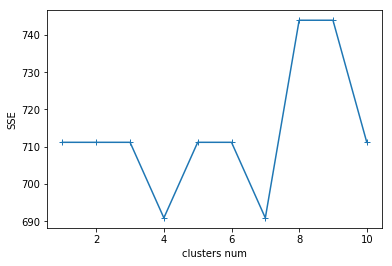

In [14]:
SSE_list = []
for i in range(1, 10+1):
    SKM = ScratchKMeans(n_clusters=3, n_init=3, max_iter=200, tol=0.0001)
    SKM.fit(X)
    sse = SSE(X,SKM.min_best)
    SSE_list.append(sse)
print(SSE_list)

# x軸は1~10のクラスタ、y軸はSSE
plt.plot(range(1,10+1),SSE_list,marker='+')
plt.xlabel('clusters num')
plt.ylabel('SSE')

### 考察
4個か7個が適していると見れる。

### クラスタ分析 卸売業者のデータ分析

In [15]:
# データの読み込み
wholesale = pd.read_csv('../kaggle/Wholesale customers data.csv')
wholesale.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [16]:
# カラム名
wholesale.columns

Index(['Channel', 'Region', 'Fresh', 'Milk', 'Grocery', 'Frozen',
       'Detergents_Paper', 'Delicassen'],
      dtype='object')

In [17]:
# データを対数変換
data = wholesale.drop(['Channel', 'Region'], axis=1)
data_log = np.log(data).values
print(data_log.shape)

(440, 6)


In [18]:
#次元削減
print('次元削減前:', data_log.shape)
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca = pca.fit(data_log)
data_pca = pca.transform(data_log)
print('次元削減後:', data_pca.shape)

次元削減前: (440, 6)
次元削減後: (440, 2)


[0.44237417 0.71894523 0.83511865 0.93129585 0.97705265 1.        ]


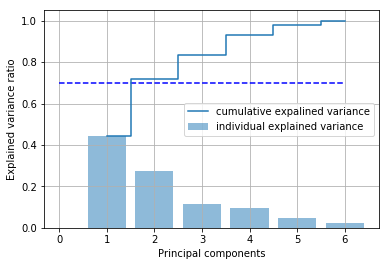

In [19]:
# PCAの分散説明率を表示するコードサンプル
pca = PCA(n_components=None)
pca = pca.fit(data_log)
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
print(cum_var_exp)
plt.bar(range(1,7), var_exp, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,7), cum_var_exp, where='mid', label='cumulative expalined variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.hlines(0.7, 0, 6,  "blue", linestyles='dashed')
plt.legend(loc='best')
plt.grid()
plt.show()

### 問題10　クラスタ数Kの選択

[3310.8160029961014, 3310.8160029961014, 3310.8160029961014, 3310.8160029961014, 3310.8160029961014, 3310.8160029961014, 3310.8160029961014, 3310.8160029961014, 3312.742926571079, 3310.8160029961014]


Text(0,0.5,'SSE')

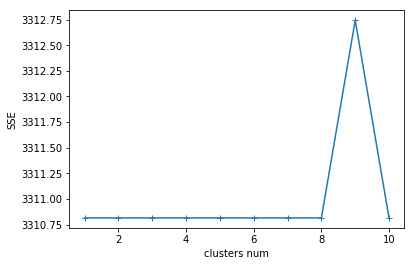

In [20]:
## SSEを入れるリストを用意
SSE_list = []

# クラスター数を1~10まで試してみる
for i in range(1, 10+1):
    SKM = ScratchKMeans(n_clusters=3, n_init=3, max_iter=200, tol=0.0001)
    SKM.fit(data_pca)
    sse = SSE(data_pca, SKM.min_best)
    SSE_list.append(sse)
print(SSE_list)

# x軸は1~10のクラスタ、y軸はSSE
plt.plot(range(1,10+1), SSE_list, marker='+')
plt.xlabel('clusters num')
plt.ylabel('SSE')

### 考察
うまくエルボーにならなかった。。

### 問題11 既知のグループとの比較

In [21]:
# 学習、推定
SKM = ScratchKMeans(n_clusters=3, n_init=5, max_iter=100, tol=0.001)
SKM_fit = SKM.fit(data_pca)
#print("\nSSE:{}".format(SSE))
SKM_pred = SKM.predict(data_pca)
SKM_pred = pd.DataFrame(SKM_pred)
SKM_pred[:4]

,0,1,clus
0,-1.750985,-0.070515,0
1,-1.800365,-0.869754,2
2,-1.893736,-1.676621,2
3,1.127313,-1.457982,2


In [22]:
channel = np.array(wholesale["Channel"])
region = np.array(wholesale["Region"])
clusters = np.array(SKM_pred["clus"])
#display(Wholesale)
#display(channel)
#print("channel",np.unique(channel, return_counts=True))
channel = np.unique(channel, return_counts=True)
channel = pd.DataFrame(channel)
channel.columns = channel.iloc[0]
channel = channel.iloc[1]
print("\nchannel", channel)

region = np.unique(region, return_counts=True)
region = pd.DataFrame(region)
region.columns = region.iloc[0]
region = region.iloc[1]
print("\nregion", region)

clusters = np.unique(clusters, return_counts=True)
clusters = pd.DataFrame(clusters)
clusters.columns = clusters.iloc[0]
clusters = clusters.iloc[1]
print("\nclusters",clusters)


channel 0
1    298
2    142
Name: 1, dtype: int64

region 0
1     77
2     47
3    316
Name: 1, dtype: int64

clusters 0
0    143
1    148
2    149
Name: 1, dtype: int64


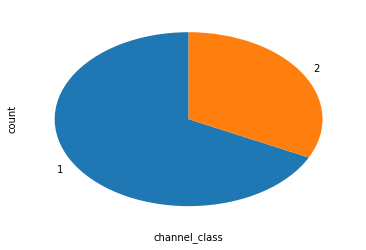

In [23]:
label = [1,2]

plt.ylabel('count')
plt.xlabel('channel_class')
plt.pie(channel, labels = label, startangle=90,)
#plt.plot(y_pred)
plt.grid()
plt.show()

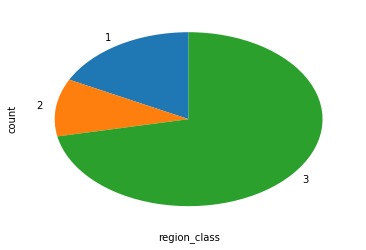

In [24]:
label = [1,2,3]

plt.ylabel('count')
plt.xlabel('region_class')
plt.pie(region, labels = label, startangle=90,)
#plt.plot(y_pred)
plt.grid()
plt.show()

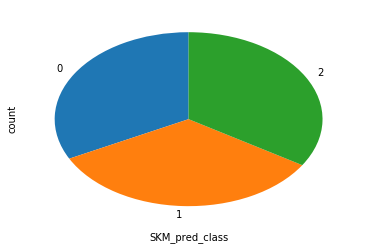

In [25]:
label = [0,1,2]

plt.ylabel('count')
plt.xlabel('SKM_pred_class')
plt.pie(clusters, labels = label, startangle=90,)
#plt.plot(y_pred)
plt.grid()
plt.show()

### 考察
クラス数３でScratchKMeansで推定を行ったところ、人数が均等に割れた。channelクラスはクラス数２でクラス１に多く分布が偏っており、regionクラスはクラス数３でクラス３に分布が偏っていた。

### 問題12 卸売業者にとって有益な情報
卸売業者にとって有益な情報を探し出し文章にまとめなさい。

《ヒント》

前処理を行う前のデータを使い、各クラスタの要約統計量を見るなどしてみましょう。また、PCAで次元削減したデータに対してK-meansを使用しましたが、6個の特徴量をそのまま使ったり、一部の特徴量のみを使ったりということも試してみてください。既知のグループとの比較結果も参考にしてください。

条件ごとにデータを見る際にはPandasのgroupbyが便利です。

pandas.DataFrame.groupby — pandas 0.23.4 documentation

In [26]:
# Wholesaleデータにclusterを追加する
wholesale_clus = pd.concat([wholesale, SKM_pred['clus']], axis=1)
wholesale_clus.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,clus
0,2,3,12669,9656,7561,214,2674,1338,0
1,2,3,7057,9810,9568,1762,3293,1776,2
2,2,3,6353,8808,7684,2405,3516,7844,2
3,1,3,13265,1196,4221,6404,507,1788,2
4,2,3,22615,5410,7198,3915,1777,5185,1


### clus ごとに各項目を平均する

In [27]:
wholesale_clus.groupby(["clus"]).mean().round()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
clus,,,,,,,,
0,1.0,3.0,10949.0,5716.0,8283.0,2455.0,2955.0,1471.0
1,1.0,3.0,11944.0,5780.0,7822.0,3564.0,2894.0,1712.0
2,1.0,3.0,13065.0,5890.0,7761.0,3175.0,2799.0,1390.0


## 考察（clus)
・生鮮品、冷凍食品、惣菜はクラス１の平均が高い
・ミルク、食品、洗剤、紙はクラスごとの差がそれほどない

### Channel ごとに各項目の平均を求める

In [28]:
wholesale_clus.groupby(["Channel"]).mean().round()

,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,clus
Channel,,,,,,,,
1,3.0,13476.0,3452.0,3962.0,3748.0,791.0,1416.0,1.0
2,3.0,8904.0,10716.0,16323.0,1653.0,7270.0,1753.0,1.0


## 考察(Channel)
・生鮮品、冷凍品はクラス１の平均が高い
・ミルク、食品、洗剤・紙はクラス２の平均が高い
・惣菜はややクラス２の平均が高い

## Regionごとに各項目の平均を求める

In [29]:
wholesale_clus.groupby(["Region"]).mean().round()

,Channel,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,clus
Region,,,,,,,,
1,1.0,11102.0,5486.0,7403.0,3000.0,2651.0,1355.0,1.0
2,1.0,9888.0,5088.0,9219.0,4045.0,3687.0,1160.0,1.0
3,1.0,12533.0,5977.0,7896.0,2945.0,2818.0,1621.0,1.0


## 考察(Region)
・生鮮品、ミルク、惣菜はクラス３の平均が高い
・食品、冷凍品、洗剤、紙はクラス２の平均が高い